# Coupon redemption classification model
**We know from the dataset that 70% of the customers never use the coupons they receive and this would lead to a waste of money and time for the company.
My objective here is to create a classification model to predict if a customer will redeem its coupons or not for the last 5 campaigns of the year. Beyond knowing which customers will redeem their coupons, it can be more interesting for a company to identify which customers won't redeem them in order to either decide on different marketing and communication actions for reaching them or to not send them coupon at all and save money.**

### Table of Contents

* [1. Dataset Creation](#section_1)
    * [A. Demographic data](#section_1_1)
    * [B. Campaign data](#section_1_2)
    * [C. Coupon redemption data](#section_1_3)
    * [D. Transaction data](#section_1_4)  
    ___
* [2. Data Exploration](#section_2)
    * [A. Shape of our data](#section_2_1)
    * [B. Data types and data completeness](#section_2_2)
    * [C. Statistical summary](#section_2_3)
    * [D. Class distribution](#section_2_4)
    * [E. Variable encoding and split](#section_2_5)
    * [F. Skew of univariate distribution](#section_2_6)
    * [G. Correlation between attributes](#section_2_7)
    ---
* [3. Data Preprocessing](#section_3)
    * [A. Split into train test](#section_3_1)
    * [B. Data transformation](#section_3_2)
    * [C. Feature selection](#section_3_3)
   ___
* [4. Model Creation](#section_4)
    * [A. Baseline model](#section_4_1)
    * [B. Model hyperparameter tuning](#section_4_2)
    ___
* [5. Model Results](#section_5)
    * [A. Accuracy and Precision scores](#section_5_1)
    * [B. Learning curve](#section_5_2)
    * [C. Confusion matrix](#section_5_3)
    ---

# 1. Dataset Creation <a class="anchor" id="section_1"></a>

In [1]:
import warnings
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import Counter
from sklearn.decomposition import PCA
%matplotlib inline
warnings.filterwarnings('ignore')

import xgboost as xgb
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
data_folder = "/kaggle/input/dunnhumby-the-complete-journey/"

/kaggle/input/dunnhumby-the-complete-journey/campaign_table.csv
/kaggle/input/dunnhumby-the-complete-journey/causal_data.csv
/kaggle/input/dunnhumby-the-complete-journey/coupon.csv
/kaggle/input/dunnhumby-the-complete-journey/campaign_desc.csv
/kaggle/input/dunnhumby-the-complete-journey/product.csv
/kaggle/input/dunnhumby-the-complete-journey/transaction_data.csv
/kaggle/input/dunnhumby-the-complete-journey/hh_demographic.csv
/kaggle/input/dunnhumby-the-complete-journey/coupon_redempt.csv


### Demographics data <a class="anchor" id="section_1_1"></a>
This table contains several demographics information concerning __802 regular customers__. let's load the data and start an exploratory data analysis 

In [2]:
df = dict()
df["hh_demographic"] = pd.read_csv(data_folder + "hh_demographic.csv")
demographic=df["hh_demographic"]
demographic["MARITAL_STATUS_CODE"].replace(['A', 'B', 'U'],['Married','Unknown','Single'],inplace=True)

demographic

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,Single,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,Single,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,Unknown,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,Married,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,Single,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


### Campaign data <a class="anchor" id="section_1_2"></a>
The tables campaign_table and campaign_desc contains all the campaign information. As we want to predict the customers that won't redeem their coupons for the __next 5 planned campaigns__, we will create our model based on all the previous campaigns. 
We can see that the last five campaigns are campaigns number __21, 22, 23, 24 and 25__.

In [3]:
df["campaign_desc"] = pd.read_csv(data_folder+"campaign_desc.csv")
campaign_desc=df["campaign_desc"]
#Sort campaign by start date
campaign_desc=campaign_desc.sort_values(by=['START_DAY','CAMPAIGN'],ascending=True)
campaign_desc

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
29,TypeA,26,224,264
28,TypeC,27,237,300
27,TypeB,28,259,320
26,TypeB,29,281,334
25,TypeA,30,323,369
23,TypeB,1,346,383
24,TypeB,2,351,383
20,TypeC,3,356,412
22,TypeB,4,372,404
21,TypeB,5,377,411


In [4]:
#We exclude the last five campaigns filtering on campaigns starting before days 615. we don't consider campaign 20
campaign_desc = campaign_desc[campaign_desc['START_DAY']<615]

The table campaign_table tells us which customers received a specific campaign.

In [5]:
df["campaign_table"] = pd.read_csv(data_folder+"campaign_table.csv")
campaign_table=df["campaign_table"]
campaign_table.head(10)

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26
5,TypeA,187,26
6,TypeA,183,26
7,TypeA,142,26
8,TypeA,140,26
9,TypeA,134,26


From this point we can merge the two campaign tables

In [6]:
#We call campaign the new dataframe merging the dataset
campaign = pd.merge(campaign_desc[['CAMPAIGN','START_DAY']],campaign_table[['household_key','CAMPAIGN']],on="CAMPAIGN",how="left")
#Count number of campaign per household
campaign['#campaign']=campaign.groupby(by='household_key')['CAMPAIGN'].transform('count')
#Delete useless column
campaign=campaign.drop(columns=['CAMPAIGN','START_DAY'])
#Delete duplicates
campaign.drop_duplicates(subset=['household_key', '#campaign'], keep="first", inplace=True)
campaign

,household_key,#campaign
0,17,5
1,27,7
2,212,5
3,208,7
4,192,3
...,...,...
6110,1744,1
6115,1594,1
6119,1479,1
6121,1447,1


### Coupon redemption data <a class="anchor" id="section_1_3"></a>
This table contains all the coupons that have been redeemed by each customer. We will use it to count how many coupons a customer redeemed for each campaign.<br>
We will follow the below steps :
- Loading the dataset
- Retrieving coupons redeemed before Day 615
- Count the number of campaign for which at least one coupon has been redeemed
- Merge our campaign table, coupon redemption table and demographic table
- Define if a customer is sensitive to coupon or not

In [7]:
#Read the coupon_redempt table
df["coupon_redempt"] = pd.read_csv(data_folder+"coupon_redempt.csv")
coupon_redempt=df["coupon_redempt"]
#Keep only coupon redeemed before DAY 615
coupon_redempt=coupon_redempt[coupon_redempt['DAY']<615]
#Drop useless columns
coupon_redempt=coupon_redempt.drop(columns=['DAY','COUPON_UPC'])
#Keep only one occurence of coupon redeemed by campaign
coupon_redempt.drop_duplicates(subset=['household_key', 'CAMPAIGN'], keep="first", inplace=True)
#Count number of campaign the customer redeemed at least one coupon
redemption_per_household=coupon_redempt.groupby(['household_key'], as_index=False)['CAMPAIGN'].agg({'redeemed': pd.Series.nunique})
redemption_per_household

,household_key,redeemed
0,1,2
1,8,1
2,13,6
3,14,1
4,18,3
...,...,...
392,2481,2
393,2488,4
394,2489,5
395,2496,3


In [8]:
#Merging of campaign and coupon redemption tables
temp = pd.merge(campaign, redemption_per_household, on=['household_key'],how="left")
#Creation of our output variable
temp["Sensitivity"]= np.where(temp["redeemed"]>0, 'Sensible', 'Not sensible')
#Creation of our aggregated dataset. We use the inner join to keep only customers for which we have the demographics data and thoose who were part of at least one campaign
dataset= pd.merge(demographic, temp[['household_key','Sensitivity']], on=['household_key'],how="inner")

### Transactions data <a class="anchor" id="section_1_4"></a>
This table contains all the transactions made by customers during 2 years. it contains 12 columns and 2 595 732 rows.
We will use the transactional dataset to create some features for our model :
- Total sales between day 1 and day 615
- Total number of visits in the shops
- Median basket spend by customer
- Average product price purchased by customer

To clean the dataset, we will follow the below steps :
- Load the data
- Keep sales before day 615
- Exclude transaction with sales value and quantity inferior or equal to 0

In [9]:
# load the dataset
df["transaction_data"] = pd.read_csv(data_folder+"transaction_data.csv")
transaction=df["transaction_data"]
#Keep transaction before day 615
transaction=transaction[transaction['DAY']<615]
#Exclude transactions related to returns
transaction=transaction[transaction['SALES_VALUE']>0]
transaction=transaction[transaction['QUANTITY']>0]
transaction.head(20)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


__Feature creation and table merging__

In [10]:
#Calculate total sales per customer
total_sales=transaction.groupby(by='household_key', as_index=False)['SALES_VALUE'].sum().rename(columns={'SALES_VALUE': 'Total_sales'})
#Calculate total number of visits per customer
total_visits=transaction.groupby(['household_key'], as_index=False)['BASKET_ID'].agg({'total_visits': pd.Series.nunique})
#Calculate median basket amount per customer
temp_basket=transaction.groupby(['household_key','BASKET_ID'], as_index=False)['SALES_VALUE'].sum()
temp_median_basket=temp_basket.groupby(['household_key'], as_index=False)['SALES_VALUE'].median().rename(columns={'SALES_VALUE': 'median_basket'})
#Calculate average product price bought per customer
temp_product=transaction.groupby(['household_key'], as_index=False)['SALES_VALUE'].mean().rename(columns={'SALES_VALUE': 'avg_price'})
dataset=dataset.merge(total_sales,on='household_key').merge(total_visits,on='household_key').merge(temp_median_basket,on='household_key').merge(temp_product,on='household_key')
dataset=dataset.drop(columns=['household_key'])
dataset

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Sensitivity,Total_sales,total_visits,median_basket,avg_price
0,65+,Married,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,Sensible,3612.54,71,48.500,2.526252
1,45-54,Married,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,Not sensible,2420.12,42,44.320,2.713139
2,25-34,Single,25-34K,Unknown,2 Adults Kids,3,1,Sensible,4387.35,96,34.090,2.875066
3,25-34,Single,75-99K,Homeowner,2 Adults Kids,4,2,Sensible,10864.94,224,40.000,5.742569
4,45-54,Unknown,50-74K,Homeowner,Single Female,1,None/Unknown,Not sensible,1486.02,93,13.730,2.936798
...,...,...,...,...,...,...,...,...,...,...,...,...
746,35-44,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,Not sensible,1569.24,27,51.240,3.666449
747,45-54,Married,75-99K,Homeowner,Unknown,3,1,Sensible,3898.51,56,72.095,2.935625
748,45-54,Single,35-49K,Unknown,Single Male,1,None/Unknown,Not sensible,5947.91,190,17.130,3.474246
749,25-34,Single,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,Not sensible,2348.11,145,9.270,3.029819


# 2. Data exploration <a class="anchor" id="section_2"></a>
Now our dataset is ready, let's discover it with descriptive statistics

### A. Shape of our data <a class="anchor" id="section_2_1"></a>
Let's use the shape() method to know the dimensions of our dataset :

In [11]:
print(dataset.shape)

(751, 12)


We have __12 variables__ and __751 observations__ in our dataset

### B. Data types and data completeness <a class="anchor" id="section_2_2"></a>
Let's use the __*info()*__ function to get more information about our dataframe as variables types and data completness :

In [12]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751 entries, 0 to 750
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE_DESC             751 non-null    object 
 1   MARITAL_STATUS_CODE  751 non-null    object 
 2   INCOME_DESC          751 non-null    object 
 3   HOMEOWNER_DESC       751 non-null    object 
 4   HH_COMP_DESC         751 non-null    object 
 5   HOUSEHOLD_SIZE_DESC  751 non-null    object 
 6   KID_CATEGORY_DESC    751 non-null    object 
 7   Sensitivity          751 non-null    object 
 8   Total_sales          751 non-null    float64
 9   total_visits         751 non-null    int64  
 10  median_basket        751 non-null    float64
 11  avg_price            751 non-null    float64
dtypes: float64(3), int64(1), object(8)
memory usage: 76.3+ KB
None


We have __8 categorical variables__ and __4 numerical values__.  
We don't have any missing value among our 751 observations.

### C. Statistical Summary <a class="anchor" id="section_2_3"></a>
Let's use the __*describe()*__ function to have a basic description of our dataset. It will enable us to have various summary statistics :

In [13]:
pd.options.display.float_format = "{:.2f}".format
dataset.describe()

,Total_sales,total_visits,median_basket,avg_price
count,751.00,751.00,751.00,751.00
mean,4856.60,152.94,27.84,3.16
std,3164.52,114.18,19.33,0.76
min,603.22,26.00,1.38,1.31
25%,2549.37,86.00,15.00,2.67
50%,4055.48,121.00,23.55,3.08
75%,6135.13,186.00,34.98,3.54
max,23805.83,1161.00,128.88,9.41


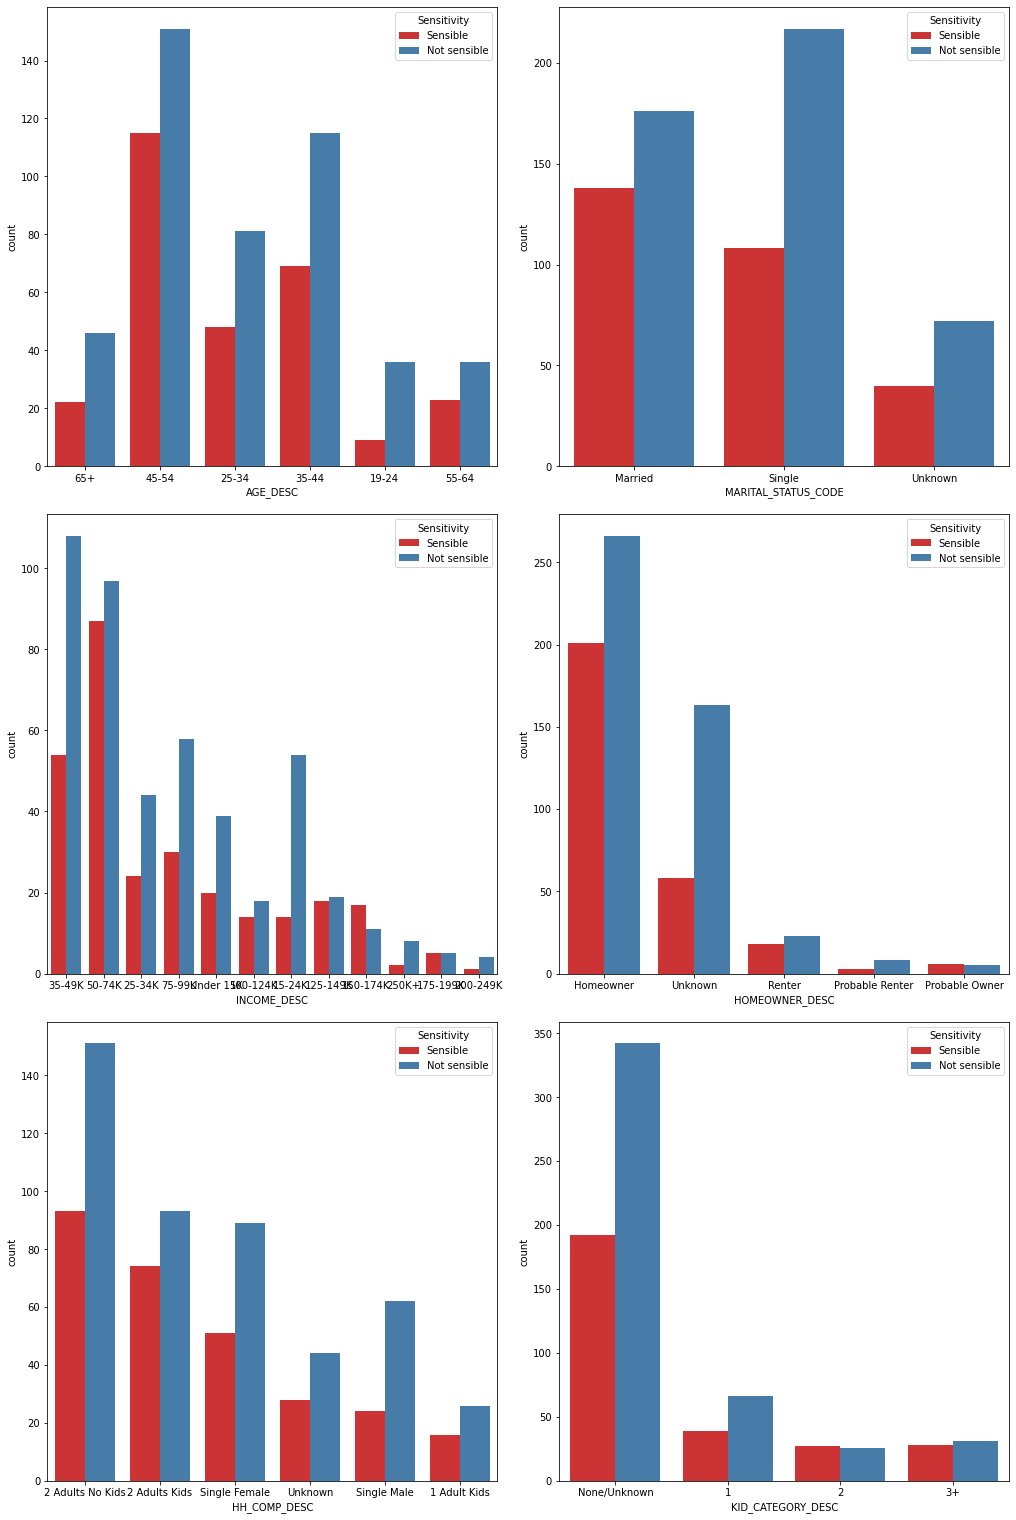

In [14]:
categorical_vars = ['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','KID_CATEGORY_DESC']
num_plots = len(categorical_vars)
total_cols = 2
total_rows = num_plots//total_cols
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
for i, var in enumerate(categorical_vars):
    row = i//total_cols
    pos = i % total_cols    
    plot = sns.countplot(x=var, data=dataset, ax=axs[row][pos],hue='Sensitivity',palette="Set1")

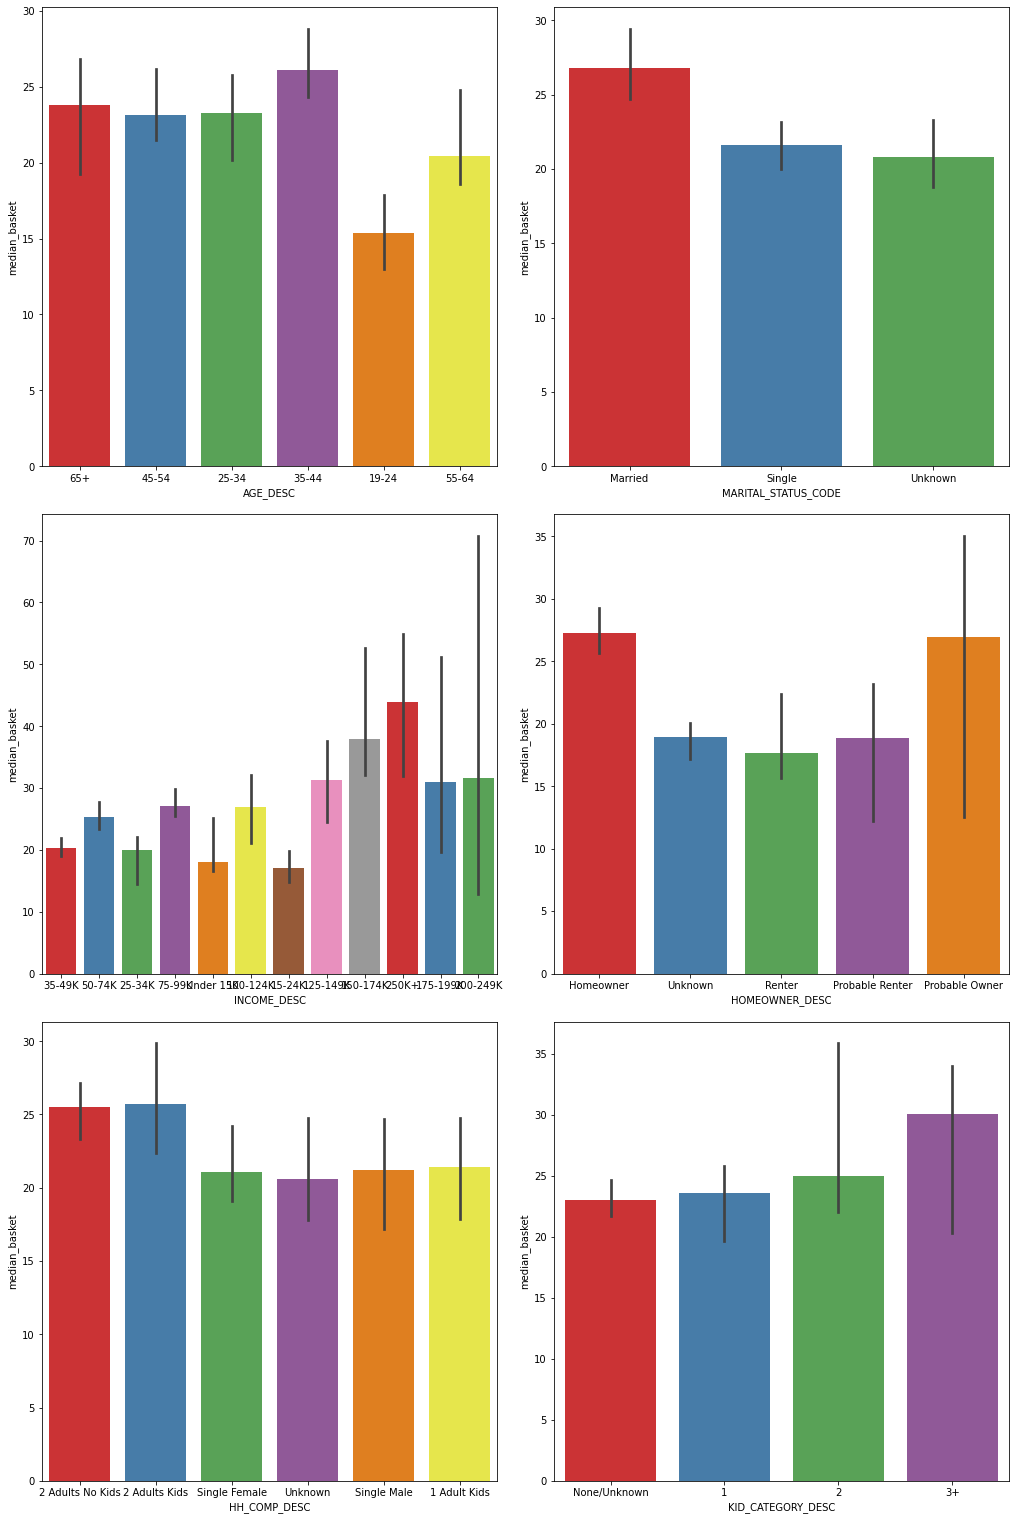

In [15]:
categorical_vars = ['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','KID_CATEGORY_DESC']
num_plots = len(categorical_vars)
total_cols = 2
total_rows = num_plots//total_cols
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
for i, var in enumerate(categorical_vars):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.barplot(x=var, y='median_basket',data=dataset, ax=axs[row][pos],palette="Set1",estimator=np.median)

We can see the median basket is the __highest__ for :
- Married households
- Households with 3 kids and more
- Households with an income superior than 250k+

### D. Class distribution <a class="anchor" id="section_2_4"></a>
On classification problems, analyzing the class distribution is always an important step as highly imbalanced data are common and need special treatment. Let's check if data are imbalanced :

In [16]:
target = dataset['Sensitivity']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.2f%%' % (k, v, per))

Class=Sensible, Count=286, Percentage=38.08%
Class=Not sensible, Count=465, Percentage=61.92%


__62%__ of our customers are not sensitive to coupons. Hence our dataset is sligthly imbalanced with more customers not sensible to coupons.<br> We will keep that in mind when choosing our cross validation technique.

### E. Variable encoding and split <a class="anchor" id="section_2_5"></a>
These two intermediate steps are needed in order to :
1. Separate the columns of our dataset into input patterns (X) and output patterns (Y)
2. Transform our eight categorical variables in numeric variables

In [17]:
#1. Split data into X and Y
X=dataset.drop(columns=['Sensitivity'])
Y=dataset['Sensitivity']

#2.A. Encode string class values as integers
label_encoder = preprocessing.LabelEncoder()
label_encoder = label_encoder.fit(dataset['Sensitivity'])
label_encoded_y = label_encoder.transform(dataset['Sensitivity'])

#2.A. Encode Income values as integers
X['INCOME_DESC'].replace(['Under 15K', '15-24K', '25-34K', '35-49K', '50-74K', '75-99K', '100-124K', '125-149K', '150-174K', '175-199K', '200-249K', '250K+'],[0,1,2,3,4,5,6,7,8,9,10,11],inplace=True)

#2.A. Encode Income values as integers
X['AGE_DESC'].replace(['19-24', '25-34', '35-44', '45-54', '55-64', '65+'],[0,1,2,3,4,5],inplace=True)

#2.A. Label encoding the other categorical data
labelencoder_X_1 = LabelEncoder()
X['MARITAL_STATUS_CODE'] = labelencoder_X_1.fit_transform(X['MARITAL_STATUS_CODE'])
labelencoder_X_2 = LabelEncoder()
X['HOMEOWNER_DESC'] = labelencoder_X_2.fit_transform(X['HOMEOWNER_DESC'])
labelencoder_X_3 = LabelEncoder()
X['HH_COMP_DESC'] = labelencoder_X_3.fit_transform(X['HH_COMP_DESC'])
labelencoder_X_4 = LabelEncoder()
X['HOUSEHOLD_SIZE_DESC'] = labelencoder_X_4.fit_transform(X['HOUSEHOLD_SIZE_DESC'])
X["KID_CATEGORY_DESC"].replace(['None/Unknown','3+'],[0,3],inplace=True)
X['HOUSEHOLD_SIZE_DESC'] = X.HOUSEHOLD_SIZE_DESC.astype(float)
X['KID_CATEGORY_DESC'] = X.KID_CATEGORY_DESC.astype(float)

### F. Skew of univariate distribution <a class="anchor" id="section_2_6"></a>
This steps is one of the most important as many algorithm performance would depend on the normal distribution of the variables.
XGboost is a non-parametric model and non-parametric models are rarely affected by skewed features. However normalizing features will not have a negative effect on our models’ performance. Let's check if our data are skewed :

In [18]:
#Let's plot the Skewness by decreasing order
num_feats=X.dtypes[X.dtypes!='object'].index
skew_feats=X[num_feats].skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_feats})
print(skewness)

                     Skew
total_visits         3.49
median_basket        1.95
KID_CATEGORY_DESC    1.69
Total_sales          1.63
avg_price            1.42
HOUSEHOLD_SIZE_DESC  1.06
INCOME_DESC          0.68
HOMEOWNER_DESC       0.63
MARITAL_STATUS_CODE  0.43
HH_COMP_DESC         0.39
AGE_DESC             0.10


Value close to 0 show __less skew__.  
Plotting the distribution is the fastest way to know if an attribute is Gaussian or skewed.

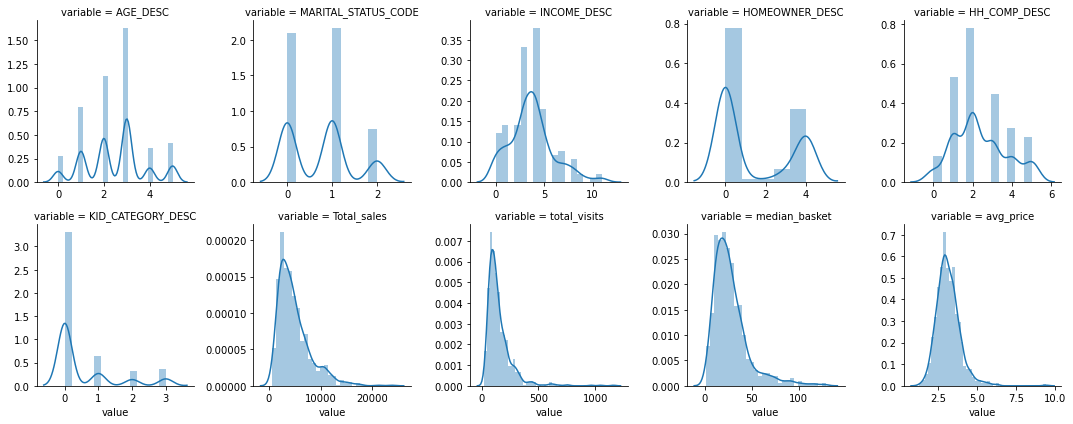

In [19]:
df = pd.DataFrame(data=X, columns=['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','KID_CATEGORY_DESC','Total_sales','total_visits','median_basket','avg_price'])
#Permet de tracer les courbes de distribution de toutes les variables
nd = pd.melt(df, value_vars =df )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=5, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

We can see we have variables with Multinomial distribution and variables with Gaussian-like distribution with a long right tail. This is confirmed with the positive values of the skewness

### G. Correlation between attributes <a class="anchor" id="section_2_7"></a>
Now we want to be sure we don't have variables with similar information. For that we will plot the correlation matrix.
Correlation refers to the relationship between two variables and how they move together.
Even if XGBoost manages very well correlated features, it's always a good step to check for multicollinearity

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,Total_sales,total_visits,median_basket,avg_price
AGE_DESC,1.00,-0.10,0.03,-0.22,0.17,-0.11,-0.22,-0.08,-0.04,0.02,0.02
MARITAL_STATUS_CODE,-0.10,1.00,-0.20,0.32,0.34,-0.52,-0.27,-0.13,0.01,-0.17,-0.11
INCOME_DESC,0.03,-0.20,1.00,-0.29,-0.05,0.12,0.06,0.21,-0.06,0.33,0.27
HOMEOWNER_DESC,-0.22,0.32,-0.29,1.00,0.25,-0.32,-0.12,-0.13,0.10,-0.29,-0.20
HH_COMP_DESC,0.17,0.34,-0.05,0.25,1.00,-0.86,-0.74,-0.14,0.00,-0.12,-0.01
HOUSEHOLD_SIZE_DESC,-0.11,-0.52,0.12,-0.32,-0.86,1.00,0.82,0.15,-0.01,0.15,0.05
KID_CATEGORY_DESC,-0.22,-0.27,0.06,-0.12,-0.74,0.82,1.00,0.13,0.02,0.08,-0.03
Total_sales,-0.08,-0.13,0.21,-0.13,-0.14,0.15,0.13,1.00,0.56,0.44,0.36
total_visits,-0.04,0.01,-0.06,0.10,0.00,-0.01,0.02,0.56,1.00,-0.38,0.04
median_basket,0.02,-0.17,0.33,-0.29,-0.12,0.15,0.08,0.44,-0.38,1.00,0.38


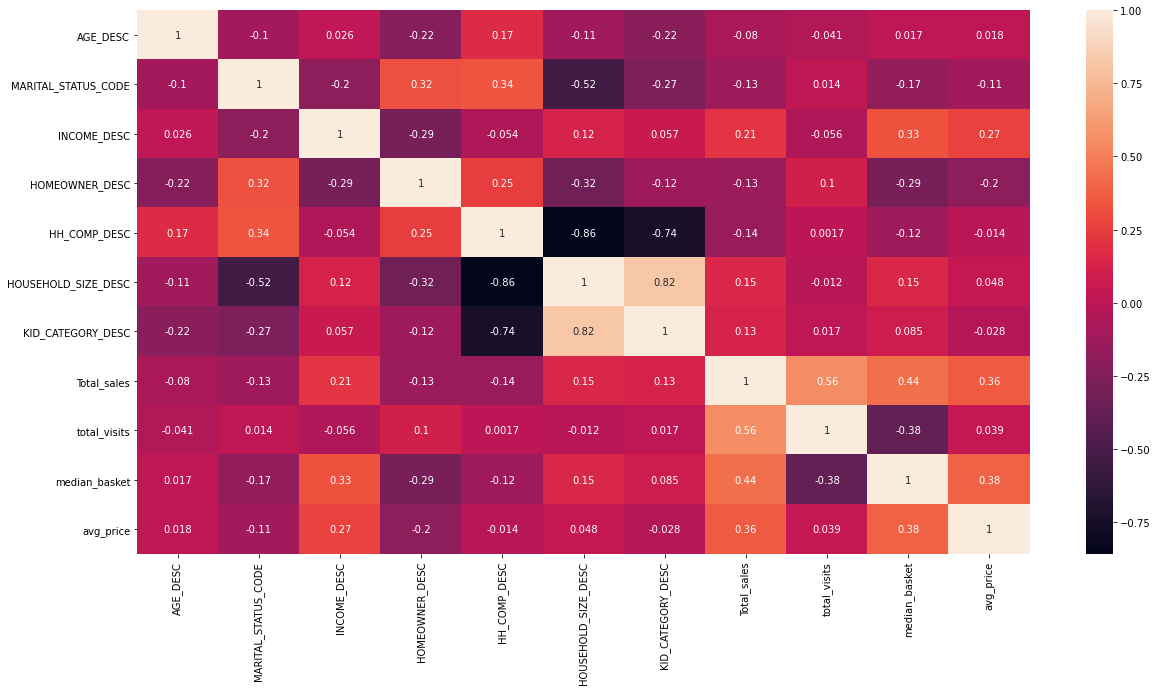

In [20]:
# Finding the relations between the variables
plt.figure(figsize=(20,10))
c= X.corr(method='spearman')
sns.heatmap(c,annot=True)
c

We can see that Households_SIZE_DESC,KID_CATEGORY_DESC and HH_COMP_DESC are correlated. Even if as said, XGboost handle correlated features, we will remove HOUSEHOLD_SIZE_DESC

In [21]:
#remove attribute
X=X.drop(columns=['HOUSEHOLD_SIZE_DESC'])

# 3. Data preprocessing <a class="anchor" id="section_3"></a>

### A. Split data into train test <a class="anchor" id="section_3_1"></a>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,label_encoded_y ,
test_size=0.3, random_state=7,shuffle=True)

### B. Data transform <a class="anchor" id="section_3_2"></a>
To give our data a more Gaussian distribution, we will use the power transform method

In [23]:
#instantiate 
pt = PowerTransformer(method='yeo-johnson', standardize=True) 

#Fit the data to the powertransformer
rescaler = pt.fit(X_train)

#Lets get the Lambdas that were found
print (rescaler.lambdas_)

calc_lambdas = rescaler.lambdas_

#Transform the data 
X_train_resc = rescaler.transform(X_train)
X_test_resc=rescaler.transform(X_test)

#Pass the transformed data into a new dataframe 
df_xt = pd.DataFrame(data=X_train_resc, columns=['AGE_DESC','MARITAL_STATUS_CODE','INCOME_DESC','HOMEOWNER_DESC','HH_COMP_DESC','KID_CATEGORY_DESC','Total_sales','total_visits','median_basket','avg_price'])

df_xt.describe()

[ 0.80567994 -0.00742699  0.62559009 -0.8781086   0.54468516 -2.93541141
  0.04739063 -0.1815103   0.1589954  -0.38965466]


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,KID_CATEGORY_DESC,Total_sales,total_visits,median_basket,avg_price
count,525.00,525.00,525.00,525.00,525.00,525.00,525.00,525.00,525.00,525.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.03,-1.13,-1.99,-0.81,-2.11,-0.63,-2.94,-3.06,-3.14,-3.60
25%,-0.33,-1.13,-0.24,-0.81,-1.04,-0.63,-0.71,-0.64,-0.67,-0.61
50%,0.43,0.56,0.21,-0.81,-0.19,-0.63,0.01,-0.04,0.02,-0.01
75%,0.43,0.56,0.63,1.29,0.53,1.46,0.64,0.67,0.63,0.64
max,1.84,1.54,2.74,1.29,1.76,1.74,3.00,3.09,3.06,4.51


Now our variables are scaled to a 0 mean and unit variance thanks to Standardization and they have a more Gaussian distribution thanks to Power Transform transformation. We can perform a PCA for feature selection  
(PCA doesn't necessarily assume the dataset to be Gaussian distributed)

### C. Feature selection <a class="anchor" id="section_3_3"></a>
We will use the PCA transformation. Our first step will be to choose the number of components

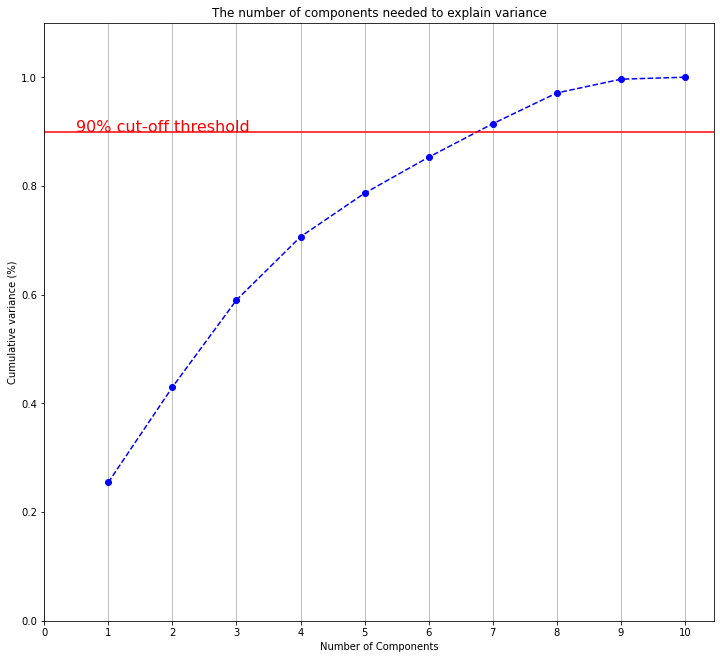

In [24]:
pca = PCA().fit(X_train_resc)

plt.rcParams["figure.figsize"] = (12,11)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.90, '90% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

We will choose the number of components that __explains 90% of the variance__. From the graph we can see that we need __7 components__.

In [25]:
# on standardized data
pca_std = PCA(n_components=7).fit(X_train_resc)
X_train_PCA = pca_std.transform(X_train_resc)
X_test_PCA = pca_std.transform(X_test_resc)
pca_std.explained_variance_ratio_

array([0.25450609, 0.17523455, 0.16027727, 0.11641416, 0.08013689,
       0.06630728, 0.06154442])

# 4. Model creation <a class="anchor" id="section_4"></a>

### A. Model baseline <a class="anchor" id="section_4_1"></a>

In [26]:
from sklearn.model_selection import cross_val_score

#check the performance of the XGBoost model without tune parameters
# fit model on training data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
model = xgb.XGBClassifier()
kfold = StratifiedKFold(n_splits=5, random_state=7,shuffle=True)


Accuracy = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='accuracy')
Precision = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='precision')

print("Accuracy: %.1f%% (%.1f%%)" % (Accuracy.mean()*100, Accuracy.std()*100))
print("Precision: %.1f%% (%.1f%%)" % (Precision.mean()*100, Precision.std()*100))

Accuracy: 66.7% (4.3%)
Precision: 55.8% (8.7%)


To assess the performance of our model, we will concentrate on __two evaluation metrics :__  
- Accuracy
- Precision  

Precision is very interesting here as we would like to minimize as much as possible __Type 1 error__ also known as False positive. Indeed, we would like to avoid the case where a customer is predicted to be sensitive to coupons while in fact he is not. This would lead to money loss as we would print and send him/her coupons for nothing.  
Our model report an __accuracy of 66.7%__ and a __precision of 55.8%__. This means that when our model predict that a customer is sensitive to coupon, it's correct 55.8% of the time.
We will try to improve our model performance with some tuning.

### B. Model hyperparameter tuning <a class="anchor" id="section_4_2"></a>

In [27]:
# grid search to tune algorithm
model = xgb.XGBClassifier()
n_estimators = [50,100, 200, 300, 400,450, 500,600,1000]
learning_rate = [0.01,0.05,0.1,0.2]
max_depth= range(2,8)
gamma=[0, 0.25, 0.5, 0.7, 0.9, 1.0]

param_grid = dict(gamma=gamma,learning_rate=learning_rate, n_estimators=n_estimators,max_depth=max_depth)
eval_set=[(X_train_PCA, y_train), (X_test_PCA, y_test)]
kfold = StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
grid_search = GridSearchCV(model, param_grid,scoring='precision', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_PCA, y_train,early_stopping_rounds= 20,eval_metric= ["logloss"],eval_set=eval_set,verbose=20)                       

# summarize result
print("Best: %.1f%% using %s" % (grid_result.best_score_*100, grid_result.best_params_))

[0]	validation_0-logloss:0.68503	validation_1-logloss:0.68804
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[20]	validation_0-logloss:0.59981	validation_1-logloss:0.64132
[40]	validation_0-logloss:0.56170	validation_1-logloss:0.62880
[60]	validation_0-logloss:0.53557	validation_1-logloss:0.62180
[80]	validation_0-logloss:0.51357	validation_1-logloss:0.61562
[100]	validation_0-logloss:0.49641	validation_1-logloss:0.61580
[120]	validation_0-logloss:0.48069	validation_1-logloss:0.61690
Stopping. Best iteration:
[105]	validation_0-logloss:0.49222	validation_1-logloss:0.61551

Best: 62.5% using {'gamma': 0.7, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}


__We now fit model on training data with the optimized parameters found__

In [28]:
# fit model on training data
model = xgb.XGBClassifier(learning_rate = 0.05,\
                          max_depth=2,\
                          n_estimators=200,\
                          gamma=0.7,\
                          objective = 'binary:logistic',\
                         )
fit_params={'early_stopping_rounds': 20, 
            'eval_metric': 'logloss',
            'verbose': False,
            'eval_set': [(X_train_PCA, y_train), (X_test_PCA, y_test)]}
                         
kfold =  StratifiedKFold(n_splits=5, random_state=7,shuffle=True)

Accuracy = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='accuracy',fit_params = fit_params)
Precision = cross_val_score(model, X_train_PCA, y_train, cv=kfold,scoring='precision',fit_params = fit_params)

print("Accuracy: %.1f%%" % (Accuracy.mean()*100))
print("Precision: %.1f%%" % (Precision.mean()*100))

Accuracy: 69.1%
Precision: 62.5%


After hyperparameter tuning, our accuracy __improved to 69%__ and our __precision to 62%__. Let's now discover the performance of our model on the test set.

# 5. Model results <a class="anchor" id="section_5"></a>

### A. Accuracy and Precision scores <a class="anchor" id="section_5_1"></a>

In [29]:
model = xgb.XGBClassifier(learning_rate = 0.05,\
                          max_depth=2,\
                          n_estimators=200,\
                          gamma=0.7,\
                          objective = 'binary:logistic',\
                          )

eval_set = [(X_train_PCA, y_train), (X_test_PCA, y_test)]
model.fit(X_train_PCA, y_train, early_stopping_rounds=20, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False)
# make predictions for test data
predictions = model.predict(X_test_PCA)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)

print("accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print(classification_report(y_test, predictions,   labels=[1,0]))

accuracy: 67.26%
Precision: 70.00%
              precision    recall  f1-score   support

           1       0.70      0.37      0.49        94
           0       0.66      0.89      0.76       132

    accuracy                           0.67       226
   macro avg       0.68      0.63      0.62       226
weighted avg       0.68      0.67      0.65       226



Performance on test set reports an __accuracy of 67%__ and a __precision of 70%__

### B. Learning curves <a class="anchor" id="section_5_2"></a>

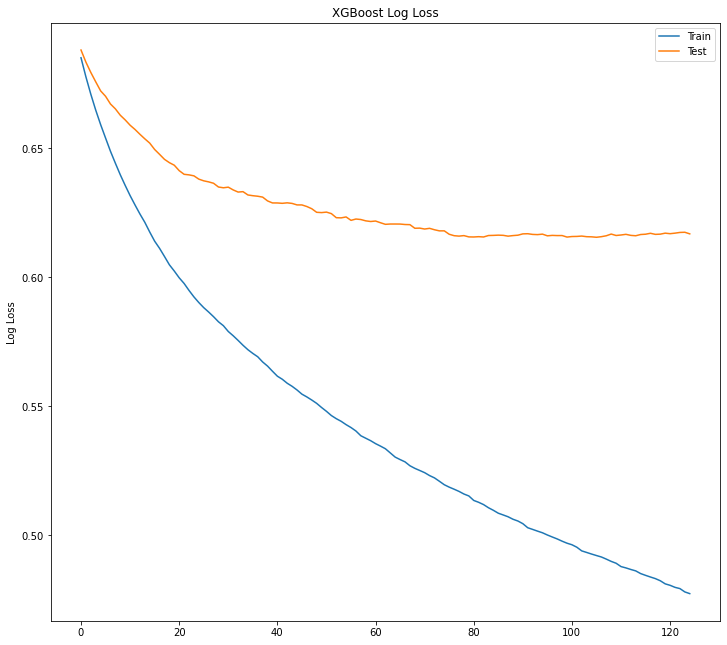

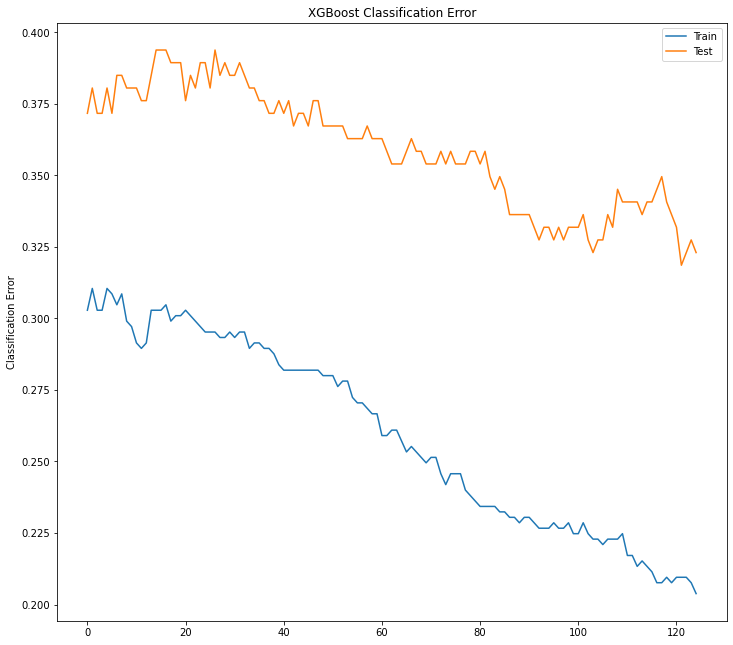

In [30]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

We can see from the graph that __overfitting has been avoided__ thanks to early stopping. The best iteration has been found earlier at __round 105__ and this is confirmed graphically : we can see the test curve start slowly increasing again at this point 

### C. Confusion matrix <a class="anchor" id="section_5_3"></a>

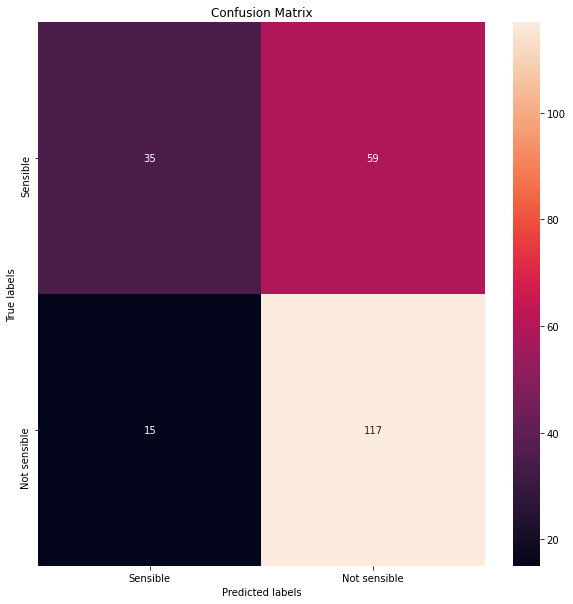

In [31]:
# confusion marix for the test data
cm = sk.metrics.confusion_matrix(y_test, predictions,  labels=[1,0])

fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sensible','Not sensible']); 
ax.yaxis.set_ticklabels(['Sensible','Not sensible']);

In conclusion we can use this model to predict if a customer is __sensitive__ to coupons __or not__. Compared to before, when we were sending coupons to customers, only 38% of them used to redeem their coupons meaning 62% of them were not interested. Now before each campaign we can use our prediction model to identify customers who won't use their coupons and either remove them from the mailing list or decide on different marketing actions to address them